# ID the Seas

### Whale and Dolphin Species classification using Convolutional Neural Networks

by Matthew Arling Samson

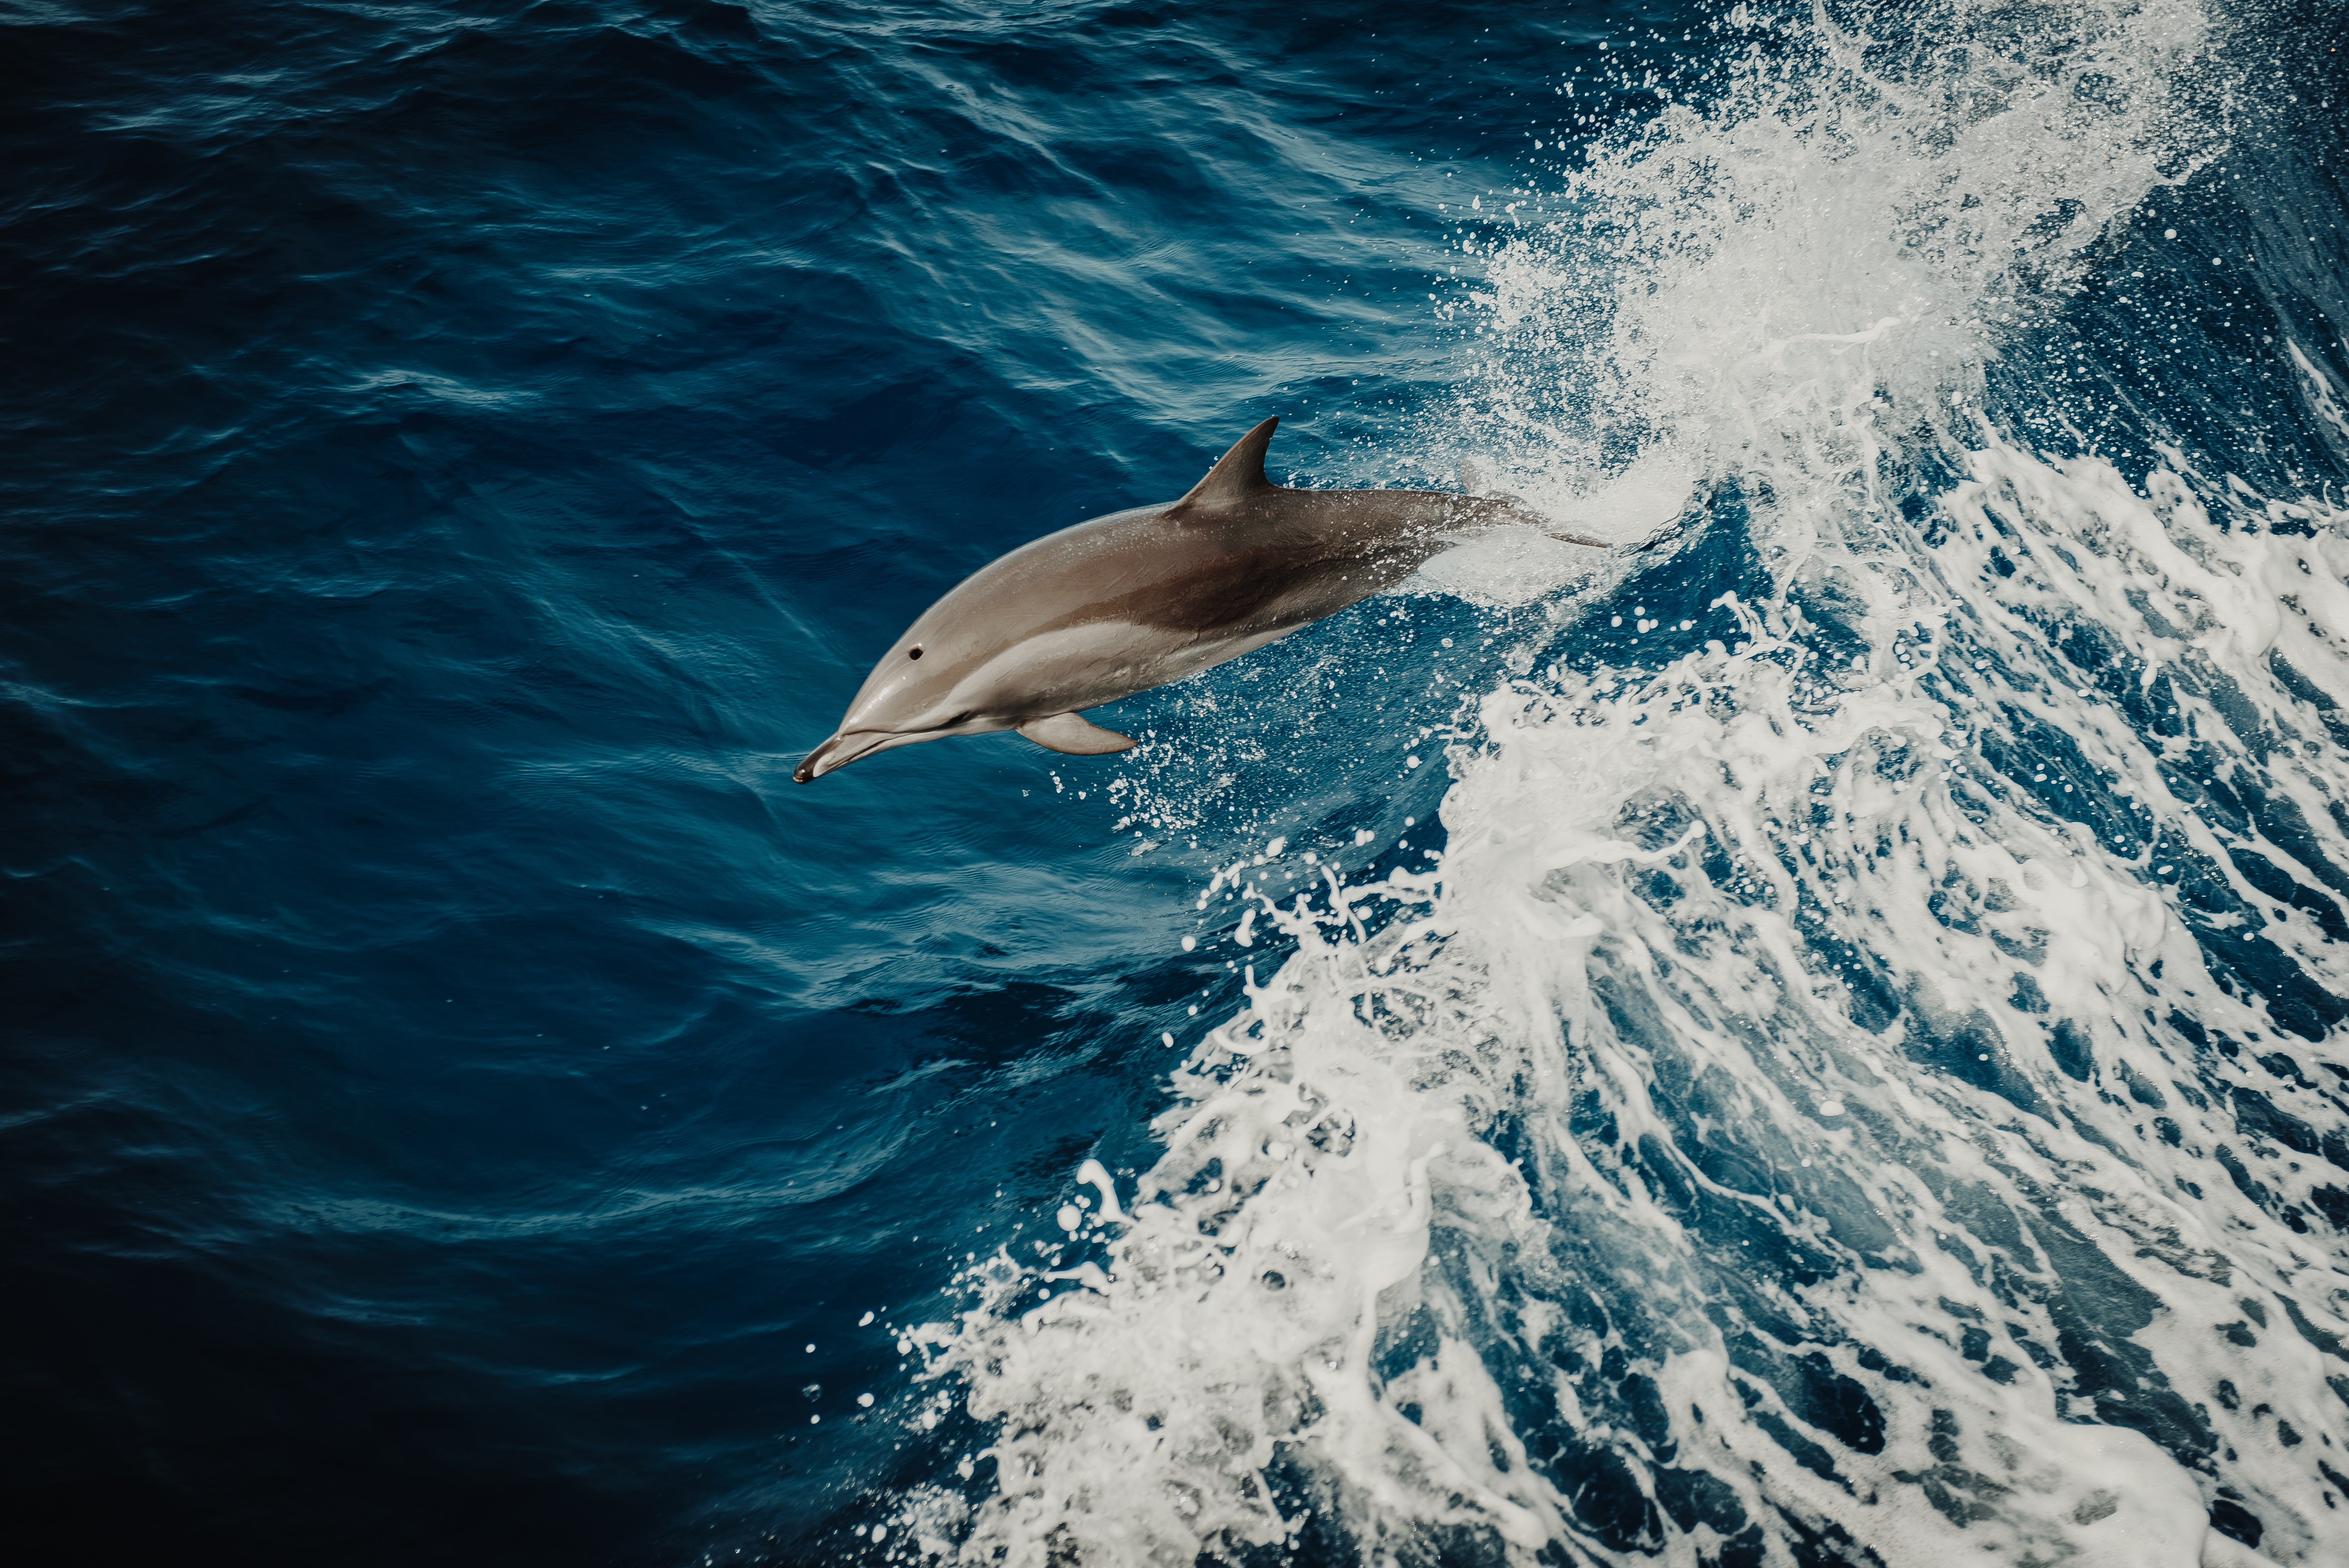

In the study of marine mammals, the ability to identify individuals or their pods is critical, allowing for population tracking over time and assessment of population trends and statistics. In this domain, there are multiple levels at which one could make meaningful contribution to groups or individuals in the field. 

At a more fundamental level, there's the task of species identification. While professional researchers would generally have no problem identifying a particular species at sight, whale watchers, citizen scientists, amateurs, and general marine enthusiasts would almost certainly benefit from quick and easy tools to aid in species ID.

For reasearchers and academics, the holy grail is individual identification. Currently, ID of individual whales and dolphins is performed manually by researchers, comparing multiple photographs side by side, checking for individual shapes and markings with just their own eyes. This is extraordinarily time consuming and not always perfectly accurate. Finding a way to do this faster would save immense amounts of time and resources that could be put to better use elsewhere.

To that end, Happywhale, a Washington state based research collaboration and citizen science platform, is seeking partners to develop machine learning models to aid in the process of whale and dolphin ID, with the hope to reduce ID times by over 99%. 

Not only that, but an app with a sufficiently accurate model would allow for such advanced individual tracking to be performed by not just professionals, but by citizen scientists and other lay people. Typical research ventures can only occur so often and encounter so many marine mammals; e.g. Baird et al, in a two week boat-based field effort had 35 encounters with 9 species of marine mammals. 40,000 photos were taken and as of publication, individual ID had not been undertaken (source: Baird, R.W., C.J. Cornforth, K.A. Wood, S.E. Vasquez, A.E. Harnish, and M.A. Kratofil. 2022. Small-Boat Surveys and Satellite Tagging of Odontocetes on the Pacific Missile Range Facility, Kauai, in August 2021. Field survey report to U.S. Pacific Fleet by HDR, under Federal contract number N6247020D0016, Task Order No. N6274221F0107). An app would not only speed up the process of identifying those individuals encountered by researchers such as these, but it would expand the number of identifiable animals by orders of magnitude by including all images of those taken during countless sightings by non-professionals. 

For now, the scope of this project includes only the first problem. However, upon completion, I will likely try my hand at the much more difficult and time-consuming second problem. Keep an eye out for additional branches.

**Note:** In this notebook, generally speaking for each new model that's been trained, the code for setting up the dataset is repeated. This is merely a convenience for ease of use should it ever be desired to rerun this notebook. With those few bits of repeated code, if one wished to rerun only a specific model, they'd need simply to run the first portion of the notebook and then the portion specific to that model, nothing else.

**On notebook cell output:** Additionally, because of the sheer amount of training performed in this notebook, and because said training can make it difficult to navigate the notebook, I've suppressed all the output from any training cells. If it is desired to see the full output from all training cells, see the notebook titled 'Final Notebook-Full Training.ipynb'. 

**Furthermore:** As it stood, the final notebook was still quite large (owing to a considerable amount of images). As such, it would not render on GitHub, so I've additionally removed quite a few images from cell outputs AND I've removed several sections in which I experimented with a number of different models. The models that I've left are the first few and the last few. Likewise to above, a notebook with all model experimentation and images can be found in the notebook titled 'Final Notebook-All Models-All Images.ipynb'.

**On Reproducibility:** The Conda environment necessary to run this project as is can be found in the main directory of this repo as environment.yml.

**On Models and Data:** Model files and data for this project are too large to be stored on GitHub. The dataset can be downloaded [here](https://www.kaggle.com/c/happy-whale-and-dolphin/data) and should be unzipped into a folder called 'data' in the same directory as this notebook. A second dataset for anomaly detection can be found [here](https://www.kaggle.com/ifigotin/imagenetmini-1000) and should be unzipped into 'data/not-whales-or-dolphins' and the folders containing killer whales and grey whales should be deleted (folders n02066245 and n02072394). 

Models can be downloaded [here](https://drive.google.com/drive/folders/1LQjT3ViklSZU469KWLJCW65KBXlwgb6G?usp=sharing) and should be stored in a folder called 'models' in the same directory as this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import PIL
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

random_state = 22222

In [2]:
# Test to see whether you have all necessary libraries for GPU support
# If so, this should output a list with at least one GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
!ls data

happy-whale-and-dolphin  local_split  not-whales-or-dolphins  random_image


In [5]:
!ls data/happy-whale-and-dolphin/

sample_submission.csv  test_images  train.csv  train_images


In [6]:
full_train_df = pd.read_csv('data/happy-whale-and-dolphin/train.csv')

full_train_df

image               species individual_id
0      00021adfb725ed.jpg    melon_headed_whale  cadddb1636b9
1      000562241d384d.jpg        humpback_whale  1a71fbb72250
2      0007c33415ce37.jpg    false_killer_whale  60008f293a2b
3      0007d9bca26a99.jpg    bottlenose_dolphin  4b00fe572063
4      00087baf5cef7a.jpg        humpback_whale  8e5253662392
...                   ...                   ...           ...
51028  fff639a7a78b3f.jpg                beluga  5ac053677ed1
51029  fff8b32daff17e.jpg  cuviers_beaked_whale  1184686361b3
51030  fff94675cc1aef.jpg            blue_whale  5401612696b9
51031  fffbc5dd642d8c.jpg                beluga  4000b3d7c24e
51032  fffdcd42312777.jpg    bottlenose_dolphin  4ddb2eeb5efb

[51033 rows x 3 columns]

In [7]:
full_train_df['species'].value_counts()

bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

Some of the species names are incorrect (e.g. "kiler_whale") and one set of species are so similar that there is more variation within each species than between species (e.g. "globis", "short_finned_pilot_whale", and "long_finned_pilot_whale"), so we'll fix that here.

In [8]:
full_train_df['species'].replace({"globis": "pilot_whale",
                          "short_finned_pilot_whale": "pilot_whale",
                          "long_finned_pilot_whale": "pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

full_train_df['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
pilot_whale                    983
southern_right_whale           866
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

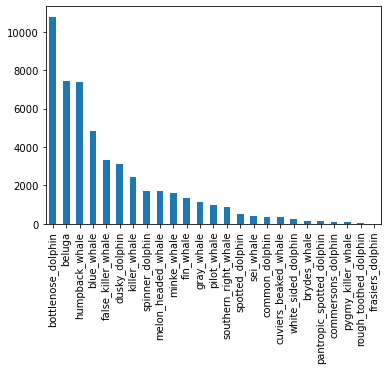

In [9]:
full_train_df['species'].value_counts().plot.bar();

# Exploring the images

In [10]:
kaggle_data_dir = 'data/happy-whale-and-dolphin/train_images'

In [11]:
species_list = list(set(full_train_df['species'].values))
species_list.sort()

In [12]:
species_list_title = [' '.join(species.split('_')).title() for species in species_list]

In [ ]:
for species in species_list:
    temp_species_df = full_train_df[full_train_df['species'] == species]
    i_list = np.random.choice(list(range(len(temp_species_df))), 3, False)
    temp_specimens_df = pd.DataFrame(temp_species_df.iloc[i_list[0],:]).T.append(temp_species_df.iloc[i_list[1],:]).append(temp_species_df.iloc[i_list[2],:])
    rand_spec_img1 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[0]))
    rand_spec_img2 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[1]))
    rand_spec_img3 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[2]))
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16,4), ncols=3)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(rand_spec_img1)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.imshow(rand_spec_img2)
    plt.text(0.5, 1.08, ' '.join(species.split('_')).title(),
         horizontalalignment='center',
         fontsize=24,
         transform = ax2.transAxes)

    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.imshow(rand_spec_img3);

Note: the output of the above cell has been supressed so that the notebook will render on GitHub.

# The train/val/test split

We'll do two sets of splits, one to create a dataset for training species recognition, and one for training individual recognition. The reason for this is that the necessary sizes of the val and test sets in the individual id recognition set are larger than we would ideally like them to be. This is because making sure that each individual ends up in the train set AND that the split is stratified requires about 6,000 photos in val and test, far more than is necessary. So the species split will be a more ideal 95/5 split, and the individual ID split will be its own irregular thing.

### The species split is fairly straightforward.

In [13]:
train_val_df_sp, test_df_sp = train_test_split(full_train_df, test_size=.05, stratify=full_train_df['species'], random_state=random_state)

In [14]:
train_df_sp, val_df_sp = train_test_split(train_val_df_sp, test_size=.05, stratify=train_val_df_sp['species'], random_state=random_state)

### The individual id split is slightly more complicated.

There are some individuals for whom only one image exists. We want to make sure they end up in the train set because if we eventually submit our work to the Kaggle competition, we'll want to have trained on them. Unfortunately, merely setting stratify inside train_test_split won't work, because there would need to be at least two images, so first, we'll move those individuals to a special dataframe that we eventually merge with our train dataframe.

In [15]:
# Pull out the individuals for whom only one image exists and put them in their own dataframe
counts = full_train_df['individual_id'].value_counts()

single_ind_df = full_train_df[full_train_df['individual_id'].isin(counts[counts == 1].index)]
partial_full_df = full_train_df[~full_train_df['individual_id'].isin(counts[counts == 1].index)]

In [16]:
single_ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9258 entries, 0 to 51018
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          9258 non-null   object
 1   species        9258 non-null   object
 2   individual_id  9258 non-null   object
dtypes: object(3)
memory usage: 289.3+ KB


In [17]:
partial_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41775 entries, 1 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          41775 non-null  object
 1   species        41775 non-null  object
 2   individual_id  41775 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [18]:
# Split on the remaining dataframe
train_val_df_id, test_df_id = train_test_split(partial_full_df, test_size=.152, stratify=partial_full_df['individual_id'], random_state=random_state)

In [19]:
train_df_id_lite, val_df_id = train_test_split(train_val_df_id, test_size=.179, stratify=train_val_df_id['individual_id'], random_state=random_state)

In [20]:
# Combine into one dataframe the unique individuals and the train group made above
train_df_id = pd.concat([single_ind_df, train_df_id_lite]).sort_index()

In [21]:
train_df_id.head()

image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

In [22]:
# Just to make sure we've done everything right
(pd.concat([train_df_id, val_df_id, test_df_id]).sort_index() == full_train_df).value_counts()

image  species  individual_id
True   True     True             51033
dtype: int64

### Organizing our data

We'll create a directory structure for our data so that we can benefit from common dataset preparation functions and methods (if we didn't, we'd have to use flow_from_dataframe on an ImageDataGenerator object, which has a few downsides further down the line; much more convenient to use image_dataset_from_directory, assuming we have the space, which we do).

In [23]:
local_dataset_imgs_names = [file for file in os.listdir(kaggle_data_dir)]
local_dataset_imgs_names[0:10]

['ea409a762ccb9e.jpg',
 '877677d8579591.jpg',
 '2b72621c2c5d4d.jpg',
 'd7d76dc67bc575.jpg',
 'dca1a94bc86c55.jpg',
 '67633fa80d8ff3.jpg',
 '0deb57aa02df74.jpg',
 'a3a03284fac201.jpg',
 'a7abfc55ca7cd7.jpg',
 'ba75165748ef8e.jpg']

In [24]:
print('There are', len(local_dataset_imgs_names), 'whale and dolphin images to be split.')

There are 51033 whale and dolphin images to be split.


In [25]:
# Create directory structure paths

local_split_dir = 'data/local_split'

sp_dir = os.path.join(local_split_dir, 'sp')
id_dir = os.path.join(local_split_dir, 'id')

train_folder_sp = os.path.join(sp_dir, 'train')
val_folder_sp = os.path.join(sp_dir, 'validation')
test_folder_sp = os.path.join(sp_dir, 'test')

train_folder_id = os.path.join(id_dir, 'train')
val_folder_id = os.path.join(id_dir, 'validation')
test_folder_id = os.path.join(id_dir, 'test')

Only run the two cells below once during initial setup.

In [26]:
# # Create directories at those paths

# os.mkdir(local_split_dir)

# os.mkdir(sp_dir)
# os.mkdir(id_dir)

# os.mkdir(train_folder_sp)
# os.mkdir(val_folder_sp)
# os.mkdir(test_folder_sp)

# os.mkdir(train_folder_id)
# os.mkdir(val_folder_id)
# os.mkdir(test_folder_id)

In [27]:
# # Make subfolders for each class

# for class_name in full_train_df['species'].unique():
#     for folder in ['train', 'validation', 'test']:
#         os.mkdir(os.path.join('data/local_split/sp', folder, class_name))
    
# for class_name in full_train_df['individual_id'].unique():
#     for folder in ['train', 'validation', 'test']:
#         os.mkdir(os.path.join('data/local_split/id', folder, class_name))

In [28]:
img_dfs = [train_df_sp, val_df_sp, test_df_sp, train_df_id, val_df_id, test_df_id]
img_names_prezip = [list(df['image'].values) for df in img_dfs]
img_names = list(zip([('sp', 'train'), ('sp', 'validation'), ('sp', 'test'), ('id', 'train'), ('id', 'validation'), ('id', 'test')], img_names_prezip))

Now we'll copy the images from kaggle's train folder into our new folder structure, according to the train/val/test split we just performed on the dataframe.

Only run this cell during initial setup.

In [29]:
for folders, img_list in img_names:
    for image in img_list:
        if folders[0] == 'sp':
            class_name = full_train_df[full_train_df['image'] == image]['species'].values[0]
        elif folders[0] == 'id':
            class_name = full_train_df[full_train_df['image'] == image]['individual_id'].values[0]
        origin = os.path.join(kaggle_data_dir, image)
        destination = os.path.join('data/local_split', folders[0], folders[1], class_name, image)
        shutil.copyfile(origin, destination)

And we'll run a loop to check for corrupted images. We can then re-import the    corrupt ones.

In [30]:
def return_corrupt():

    import filecmp

    global bads
    bads = []

    for folder in os.listdir('data/local_split'):
        for subfolder in os.listdir(os.path.join('data/local_split', folder)):
            for subsubfolder in os.listdir(os.path.join('data/local_split', folder, subfolder)):
                for image in os.listdir(os.path.join('data/local_split', folder, subfolder, subsubfolder)):
                    origin = os.path.join('data/happy-whale-and-dolphin/train_images', image)
                    destination = os.path.join('data/local_split', folder, subfolder, subsubfolder, image)
                    try:
                        if not filecmp.cmp(origin, destination):
                            bads.append((folder, subfolder, subsubfolder, image))
                    except:
                        bads.append((folder, subfolder, subsubfolder, image))
    return bads

In [31]:
def recheck_bads():

    import filecmp

    global bads
    global bads_recheck
    
    bads_recheck = []

    for image_path in bads:
        origin = os.path.join('data/happy-whale-and-dolphin/train_images', image_path[3])
        destination = os.path.join('data/local_split', image_path[0], image_path[1], image_path[2], image_path[3])
        try:
            if not filecmp.cmp(origin, destination):
                bads_recheck.append((folder, subfolder, subsubfolder, image))
        except:
            bads_recheck.append((folder, subfolder, subsubfolder, image))
    
    return bads_recheck

The next three cells should only need to be run on first unpacking the dataset.

In [31]:
# return_corrupt()

[('id', 'train', 'a4ecc3308dc5', 'f4f8b2e871b030.jpg'),
 ('id', 'train', '9afcb84d0057', '18b8357e363a01.jpg'),
 ('sp', 'train', 'humpback_whale', '6d782876d9e28a.jpg'),
 ('sp', 'train', 'brydes_whale', '94530209440cc8.jpg'),
 ('sp', 'train', 'bottlenose_dolphin', '94ecb55aac1274.jpg'),
 ('sp', 'train', 'bottlenose_dolphin', 'a32ac4baf1d991.jpg')]

In [32]:
# for image_path in bads:
#         origin = os.path.join('data/happy-whale-and-dolphin/train_images', image_path[3])
#         destination = os.path.join('data/local_split', image_path[0], image_path[1], image_path[2], image_path[3])
#         shutil.copyfile(origin, destination)

In [33]:
# recheck_bads()

[]

# Preparing our data

We'll reduce our image sizes and apply some data augmentation. 

In [34]:
image_size = (128, 128)
batch_size = 32
color_mode='grayscale'

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

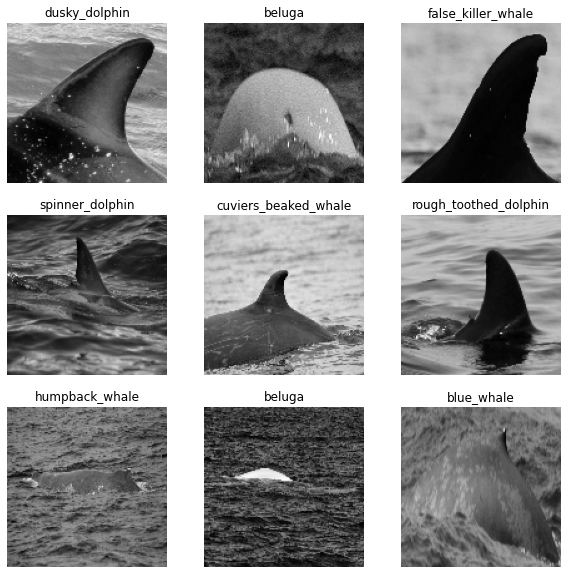

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_sp.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap='gray')
        plt.title(species_list[labels[i]])
        plt.axis("off")

# Setting up a model

In [39]:
filepath = 'models/best_model_cnn2.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [40]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.Dense(25, activation='softmax'))

adam = Adam(learning_rate=.001)
cnn2.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
cnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [ ]:
history_cnn2 = cnn2.fit(train_ds_sp,
                    epochs=20,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

In [42]:
load_file = 'models/best_model_cnn2.hdf5'

In [43]:
best_model_cnn2 = load_model(load_file)

In [44]:
best_model_cnn2.evaluate(test_ds_sp)

80/80 [==============================] - 22s 187ms/step - loss: 1.1228 - accuracy: 0.7394


[1.1228264570236206, 0.7394200563430786]

While .evaluate() only gives us loss and accuracy, this is perfectly fine as accuracy is likely the most appropriate metric to use in this case. Since this is a large multiclass problem, there is no particular advantage or disadvantage to favoring false positives over false negatives. On the other hand, if for a particular species, one or the other type of false prediction is high, then we might want to penalize that. That being the case, later on, once we have a satisfactorily high accuracy score, we can look at the performance of individual species according to their F1 score. For now, just accuracy.

# Making and visualizing random predictions

The function below will visualize and predict on a random image. Although further down in the notebook we've run several different models with different input sizes and color modes and the like, the function should work without any fuss, except on our very earliest model or two (our baseline models), which, having been trained in a previous notebook with an ImageDataGenerator instead of image_dataset_from_directory, don't play so nicely with the function. However, in notebooks/initial-setup-final.ipynb, there is a version of the function that will work with said model(s).

In [32]:
def random_prediction(model):
    
    random_image_dir = 'data/random_image'
    if 'random_image' not in os.listdir('data'):
        os.mkdir(random_image_dir)
    else:
        pass    

    for class_name in full_train_df['species'].unique():
            if class_name not in os.listdir(random_image_dir):
                os.mkdir(os.path.join(random_image_dir, class_name))    

    for folder in os.listdir(random_image_dir):
        for item in os.listdir(os.path.join(random_image_dir, folder)):
            os.remove(os.path.join(random_image_dir, folder, item))    

    i = np.random.randint(0, len(test_df_sp))
    random_image_df = pd.DataFrame(test_df_sp.iloc[i,:]).T

    actual_class = random_image_df['species'].values[0]
    origin = os.path.join(kaggle_data_dir, random_image_df['image'].values[0])
    destination = os.path.join(random_image_dir, actual_class, random_image_df['image'].values[0])
    shutil.copyfile(origin, destination)
    
    image_size = tuple(list(model.layers[0].input.shape)[1:3])
    
    if list(model.layers[0].input.shape)[3] == 3:
        color_mode = 'rgb'
    elif list(model.layers[0].input.shape)[3] == 1:
        color_mode = 'grayscale'
    
    random_image_ds = tf.keras.preprocessing.image_dataset_from_directory(random_image_dir,
                                                                          color_mode=color_mode,
                                                                          image_size=image_size,
                                                                          batch_size=1,
                                                                          )    

    random_image_pred = model.predict(random_image_ds)
    random_image_class = random_image_df.values[0][1]
    random_image_class_index = species_list.index(random_image_class)
    
    random_image = os.path.join(kaggle_data_dir, random_image_df.values[0][0])
    random_image_pil = PIL.Image.open(random_image)
    
    rand_img_pred_list = list(random_image_pred[0])
    rand_img_class_pred_index = np.where(random_image_pred == np.amax(random_image_pred))[1][0]
    rand_img_class_pred = species_list[rand_img_class_pred_index]
   
    if rand_img_class_pred != random_image_class:
        colors = ['red' if i == random_image_class_index else 'gray' for i in range(0, 25)]
    else:
        colors = ['C0' if i == random_image_class_index else 'gray' for i in range(0, 25)]
        
    class_ratio = int(round(train_df_sp['species'].value_counts().loc[random_image_class]/len(train_df_sp)*100))
    print(f'{random_image_class} makes up ca. {class_ratio}% of the training dataset.')

    fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

    ax1.grid(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(random_image_pil)
    ax1.set_title(f'Actual class: {random_image_class}')

    ax2.bar(range(len(random_image_pred[0])), list(random_image_pred[0]), color=colors)
    ax2.set_xlim(-1, 25)
    ax2.set_xticks(range(0, 25))
    ax2.set_xticklabels(species_list)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='center')
    ax2.set_title(f'Predicted Class: {rand_img_class_pred}')
    fig.savefig('models/random_image_pred', dpi=300, transparent=False, bbox_inches='tight');

Found 1 files belonging to 25 classes.
humpback_whale makes up ca. 14% of the training dataset.


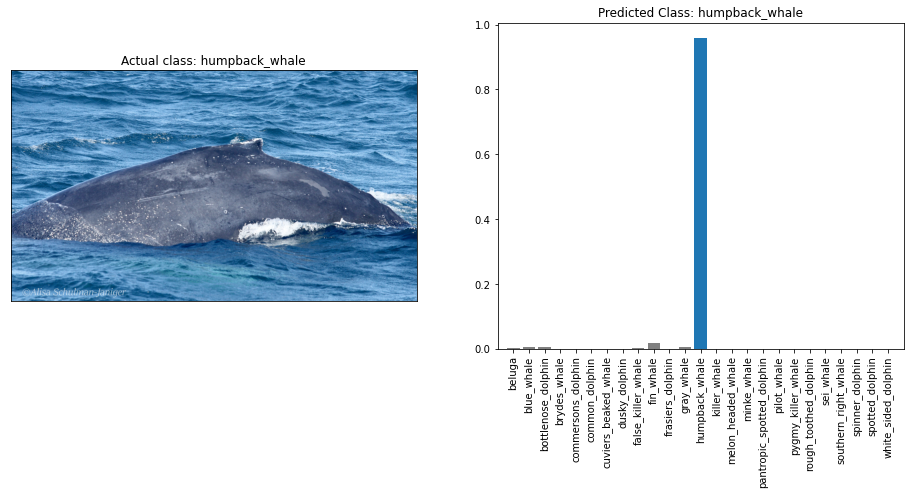

In [536]:
random_prediction(best_model_cnn2)

# And now we begin our testing with transfer learning

### We'll start with a DenseNet121

In [447]:
filepath = 'models/best_model_densenet.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=15)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [448]:
image_size = (96, 96)
batch_size = 24
color_mode = 'rgb'

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [449]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

In [450]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(.025)
    ]
)

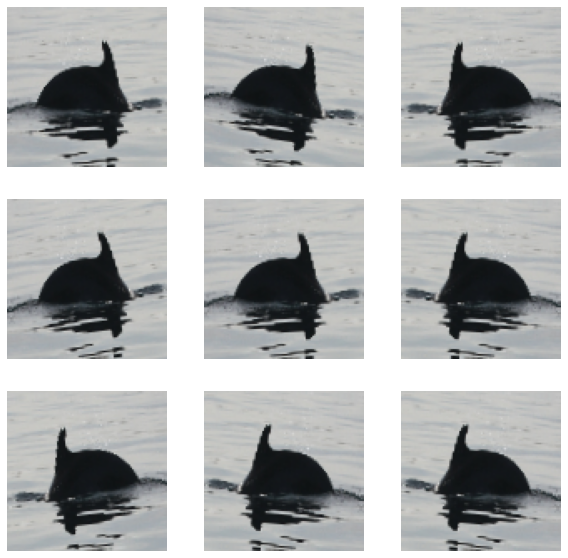

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds_sp.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [58]:
densenet_base = tf.keras.applications.DenseNet121(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=(96, 96, 3), 
                                                  pooling='max')
densenet_base.trainable = False

In [59]:
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(x)
x = densenet_base(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005))(x)
outputs = layers.Dense(25, activation='softmax')(x)

densenet = keras.Model(inputs, outputs, name='transfer_learning')
densenet.summary()

adam = Adam(learning_rate=.1)
densenet.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 7,306,329
Trainable params: 268,825
Non-trainable params: 7,037,504
_________________________________

In [ ]:
history_densenet = densenet.fit(train_ds_sp,
                                epochs=60,
                                validation_data=val_ds_sp,
                                callbacks=callbacks)

In [61]:
load_file = 'models/best_model_densenet.hdf5'

In [62]:
best_model_densenet = load_model(load_file)

In [63]:
best_model_densenet.evaluate(test_ds_sp)

107/107 [==============================] - 22s 179ms/step - loss: 2.5111 - accuracy: 0.2112


[2.511112928390503, 0.21120689809322357]

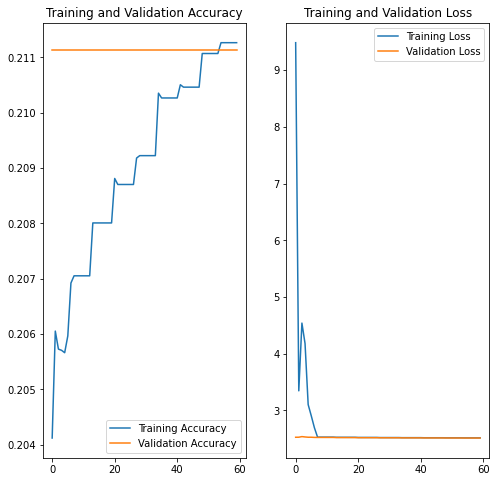

In [64]:
acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']

loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now we'll unfreeze the model in chunks and retrain with each unfreeze (we could probably come up with a more fine-tuned unfreezing strategy, but 4 large fairly evenly sized chunks will hopefully suffice). We'll lower the learning rate as well.

In [102]:
# densenet_base.layers[0:107]
# densenet_base.layers[107:213]
# densenet_base.layers[213:322]
# densenet_base.layers[322:428]

In [104]:
for layer in densenet_base.layers[322:428]:
    layer.trainable = True

In [106]:
densenet.optimizer.learning_rate = .001

In [ ]:
history2_densenet = densenet.fit(train_ds_sp,
                    epochs=20,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

In [108]:
for layer in densenet_base.layers[213:322]:
    layer.trainable = True

In [ ]:
history3_densenet = densenet.fit(train_ds_sp,
                    epochs=20,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

In [434]:
load_file = 'models/best_model_densenet.hdf5'

In [435]:
densenet = load_model(load_file)

In [446]:
for layer in densenet.layers:
    print(layer.trainable)

True
True
True
True
True
True


In [ ]:
history3_densenet = densenet.fit(train_ds_sp,
                    epochs=40,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

In [452]:
load_file = 'models/best_model_densenet.hdf5'

In [453]:
best_model_densenet = load_model(load_file)

In [454]:
best_model_densenet.evaluate(test_ds_sp)

107/107 [==============================] - 21s 170ms/step - loss: 2.5089 - accuracy: 0.2112


[2.508920431137085, 0.21120689809322357]

# DenseNet121 with no freezing

So we didn't seem to have too much luck freezing the DenseNet and then slowly unfreezing it. This could be because our dataset is sufficiently different from the ImageNet dataset for the weights to be tremendously useful. We could try starting with portions of the DenseNet unfrozen, or we could just take the opposite approach and begin with the entire model unfrozen. That said, we'll still use the pretrained weights, because they'll likely still give us some useful information and be a good starting point.

In [33]:
filepath = 'models/best_model_densenet2.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=15)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [34]:
image_size = (96, 96)
batch_size = 24
color_mode = 'rgb'

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(.025)
    ]
)

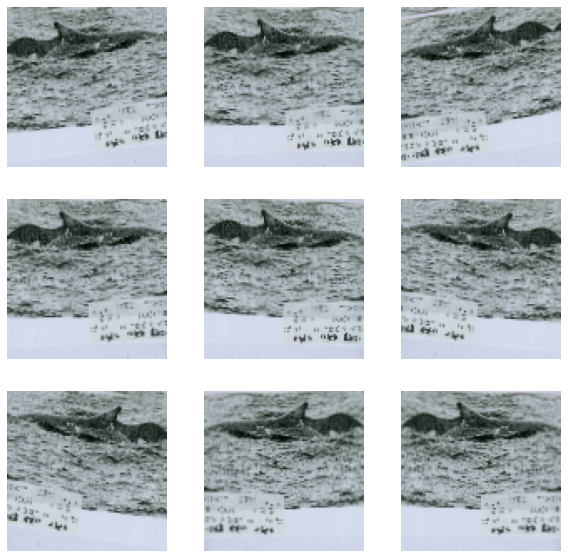

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds_sp.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [40]:
densenet2_base = tf.keras.applications.DenseNet121(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=(96, 96, 3), 
                                                  pooling='max')

In [41]:
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(x)
x = densenet2_base(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005))(x)
outputs = layers.Dense(25, activation='softmax')(x)

densenet2 = keras.Model(inputs, outputs, name='transfer_learning')
densenet2.summary()

adam = Adam(learning_rate=.001)
densenet2.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 25)                6425      
Total params: 7,306,329
Trainable params: 7,222,681
Non-trainable params: 83,648
__________________________________

In [ ]:
history_densenet2 = densenet2.fit(train_ds_sp,
                                  epochs=60,
                                  validation_data=val_ds_sp,
                                  callbacks=callbacks)

In [43]:
load_file = 'models/best_model_densenet2.hdf5'

In [44]:
best_model_densenet2 = load_model(load_file)

In [45]:
best_model_densenet2.evaluate(test_ds_sp)

107/107 [==============================] - 22s 174ms/step - loss: 0.2499 - accuracy: 0.9475


[0.24986974895000458, 0.9474921822547913]

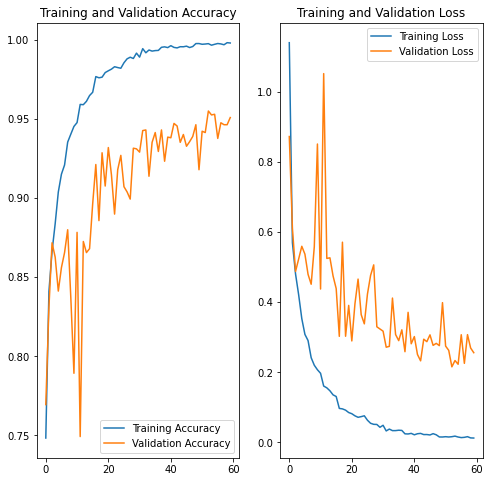

In [46]:
acc = history_densenet2.history['accuracy']
val_acc = history_densenet2.history['val_accuracy']

loss = history_densenet2.history['loss']
val_loss = history_densenet2.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history2_densenet2 = densenet2.fit(train_ds_sp,
                                   epochs=20,
                                   validation_data=val_ds_sp,
                                   callbacks=callbacks)

In [68]:
load_file = 'models/best_model_densenet2.hdf5'

In [69]:
best_model_densenet2 = load_model(load_file)

In [37]:
best_model_densenet2.evaluate(test_ds_sp)

107/107 [==============================] - 24s 155ms/step - loss: 0.2380 - accuracy: 0.9577


[0.2379976063966751, 0.9576802253723145]

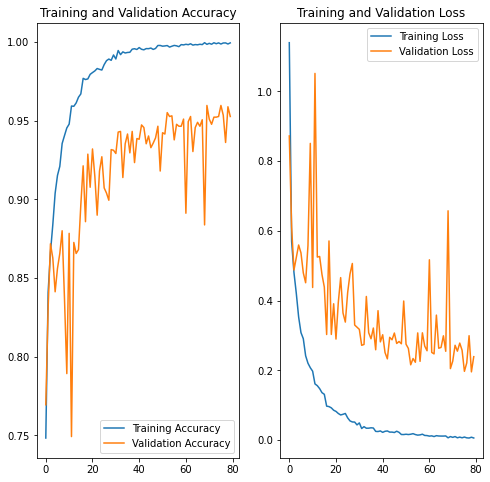

In [51]:
acc = history_densenet2.history['accuracy'] + history2_densenet2.history['accuracy']
val_acc = history_densenet2.history['val_accuracy'] + history2_densenet2.history['val_accuracy']

loss = history_densenet2.history['loss'] + history2_densenet2.history['loss']
val_loss = history_densenet2.history['val_loss'] + history2_densenet2.history['val_loss']

epochs_range = range(80)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So this is quite good. We could potentially squeeze another half a percent or so out of this, maybe more, but 96% is a decent stopping point for the problem of species identification. If we've solved the other problem and achieved all our goals with it, perhaps we might come back to this, but for now, we'll leave this as is.

Found 1 files belonging to 25 classes.
gray_whale makes up ca. 2% of the training dataset.


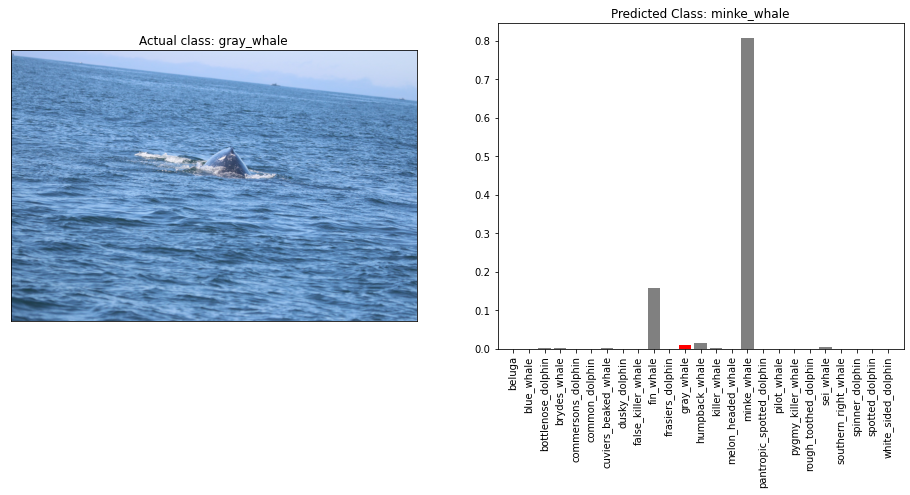

In [156]:
# Run this until you find a bad one, just to see
random_prediction(best_model_densenet2)

And we'll make a quick confusion matrix to see the species for which the model performs poorly.

In [70]:
y_proba = []
y_pred = []
y_true = []

for image_batch, label_batch in test_ds_sp:
    y_true.append(label_batch)
    preds = best_model_densenet2.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))
    y_proba.append(preds)

test_labels = tf.concat([item for item in y_true], axis = 0)
y_hat = tf.concat([item for item in y_pred], axis = 0)

In [71]:
y_proba_lists = [array.tolist() for array in y_proba]

In [72]:
y_probas = []

for list_batch in y_proba_lists:
    for sub_list in list_batch:
        y_probas.append(sub_list)

In [73]:
cf_matrix = confusion_matrix(test_labels, y_hat)

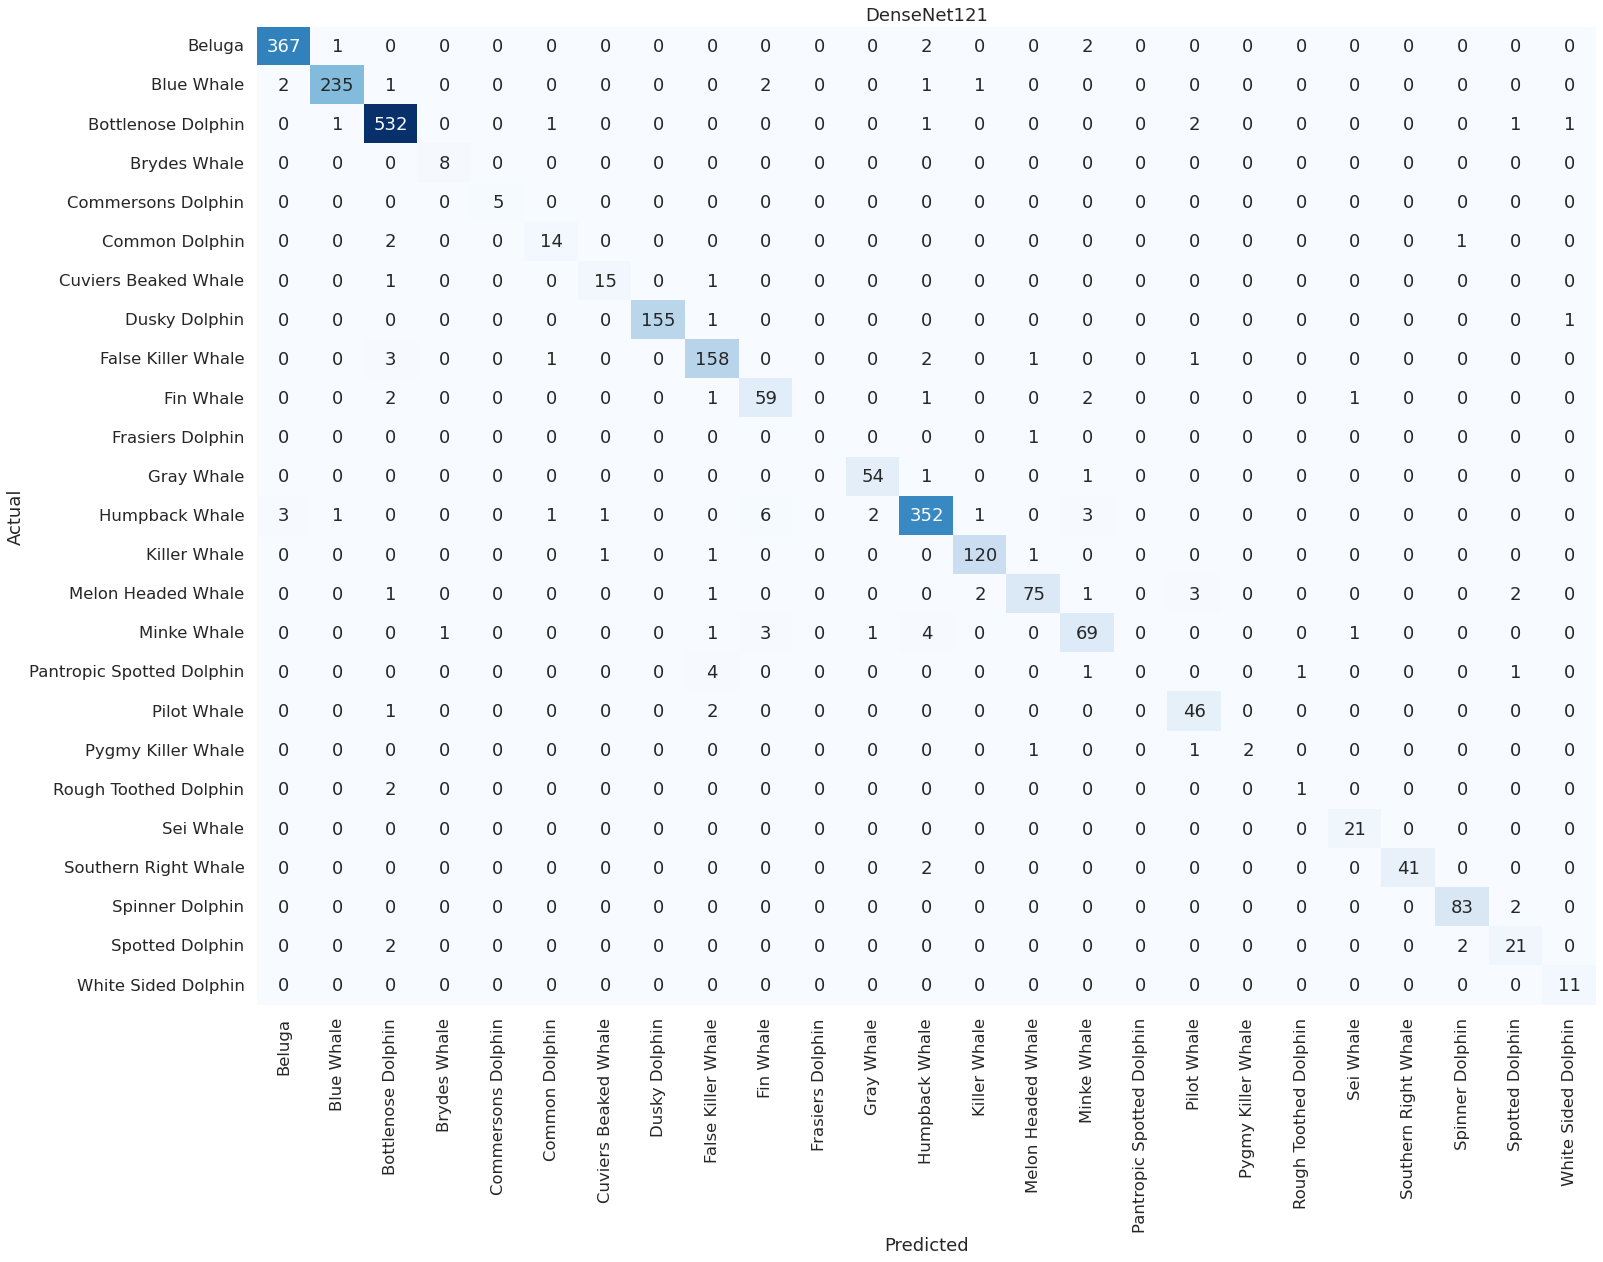

In [74]:
categories = species_list_title

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels_1 = group_counts_1
labels_1 = np.asarray(labels_1).reshape(25,25)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(24,18))

sns.heatmap(cf_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('DenseNet121');

In [75]:
print('Recall:    {}'.format(recall_score(test_labels, y_hat, average='weighted')))
print('Precision: {}'.format(precision_score(test_labels, y_hat, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(test_labels, y_hat)))
print('F1 score:  {}'.format(f1_score(test_labels, y_hat, average='weighted')))
print('AUROC:     {}'.format(roc_auc_score(test_labels, y_probas, multi_class='ovr', average='weighted')))

Recall:    0.957680250783699
Precision: 0.9552044410564517
Accuracy:  0.957680250783699
F1 score:  0.956092465828634
AUROC:     0.9985102657387466


Let's try to get a better look at specifically which classes are well predicted and which are poorly predicted.

In [76]:
# First we'll grab three handy little functions from this lovely article by Kerry Halupa 
# (https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72) 
# that will let us quickly and easily set a custom colormap. The default diverging colormaps 
# generally go through a light color in the middle, which sometimes makes it hard to see 
# certain values if they land in the right place.

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    
    value = value.strip("#")
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' 
    creates and returns a color map that can be used in heat map figures.
    If float_list is not provided, colour map graduates linearly between each color in hex_list.
    If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 

    Parameters
    ----------
    hex_list: list of hex code strings
    float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

    Returns
    ----------
    colour map
    '''
    
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

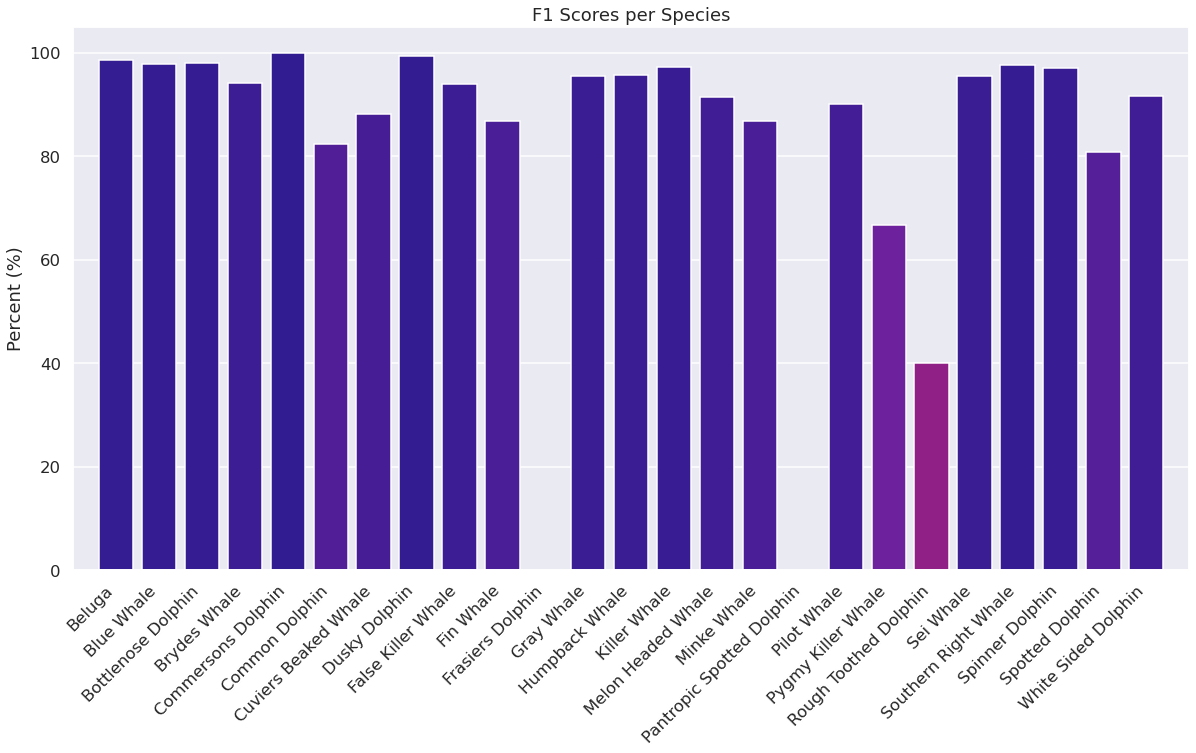

In [78]:
f1_list = [f1_score(test_labels, y_hat, labels=[i], average='weighted') for i in range(0,25)]

minima = min(f1_list)
maxima = max(f1_list)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=get_continuous_cmap(['#d10808', '#980eb9', '#2608a6']))

sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=species_list_title, y=[f1_score(test_labels, y_hat, labels=[i], average='weighted')*100 for i in range(0,25)], palette=[mapper.to_rgba(v) for v in f1_list])
ax.set(xlim=(-1, 25), ylim=(0, 105))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_ylabel('Percent (%)')
ax.set_title('F1 Scores per Species');

So our model performs rather poorly on Frasier's dolphins, pantropical spotted dolphins, rough-toothed dolphins, and, to some extent, pygmy killer whales. This is likely because they make up a very small portion of either the train or test set. Let's take a look.

In [61]:
train_df_sp.groupby('species').count()['image']

species
beluga                       6717
blue_whale                   4358
bottlenose_dolphin           9730
brydes_whale                  139
commersons_dolphin             81
common_dolphin                313
cuviers_beaked_whale          308
dusky_dolphin                2833
false_killer_whale           3002
fin_whale                    1195
frasiers_dolphin               12
gray_whale                   1014
humpback_whale               6671
killer_whale                 2215
melon_headed_whale           1524
minke_whale                  1452
pantropic_spotted_dolphin     131
pilot_whale                   887
pygmy_killer_whale             68
rough_toothed_dolphin          54
sei_whale                     387
southern_right_whale          782
spinner_dolphin              1534
spotted_dolphin               442
white_sided_dolphin           207
Name: image, dtype: int64

In [62]:
train_df_sp.loc[train_df_sp['species'].isin(['frasiers_dolphin', 'pantropic_spotted_dolphin', 'pygmy_killer_whale', 'rough_toothed_dolphin'])].groupby('species').count()['image']

species
frasiers_dolphin              12
pantropic_spotted_dolphin    131
pygmy_killer_whale            68
rough_toothed_dolphin         54
Name: image, dtype: int64

In [63]:
test_df_sp.loc[test_df_sp['species'].isin(['frasiers_dolphin', 'pantropic_spotted_dolphin', 'pygmy_killer_whale', 'rough_toothed_dolphin'])].groupby('species').count()['image']

species
frasiers_dolphin             1
pantropic_spotted_dolphin    7
pygmy_killer_whale           4
rough_toothed_dolphin        3
Name: image, dtype: int64

So it looks like these species make up a very small proportion of the train set, so that could explain the poor performance. Additionally, each of these species is quite poorly represented in the test set, which could also be a large factor, particularly for Frasier's dolphins.

But on second thought, there are other species that are also poorly represented. Let's take a look at what proportion of the dataset each species makes up.

In [64]:
train_df_sp_proportions = train_df_sp.groupby('species').count()['image']/len(train_df_sp)*100
train_df_sp_proportions

species
beluga                       14.584419
blue_whale                    9.462394
bottlenose_dolphin           21.126455
brydes_whale                  0.301806
commersons_dolphin            0.175873
common_dolphin                0.679607
cuviers_beaked_whale          0.668751
dusky_dolphin                 6.151207
false_killer_whale            6.518152
fin_whale                     2.594667
frasiers_dolphin              0.026055
gray_whale                    2.201668
humpback_whale               14.484541
killer_whale                  4.809363
melon_headed_whale            3.309015
minke_whale                   3.152684
pantropic_spotted_dolphin     0.284436
pilot_whale                   1.925916
pygmy_killer_whale            0.147646
rough_toothed_dolphin         0.117249
sei_whale                     0.840281
southern_right_whale          1.697933
spinner_dolphin               3.330728
spotted_dolphin               0.959701
white_sided_dolphin           0.449453
Name: image, dtyp

To get a better comparative picture, let's make a plot that shows each species's F1 score relative to its representation in the dataset.

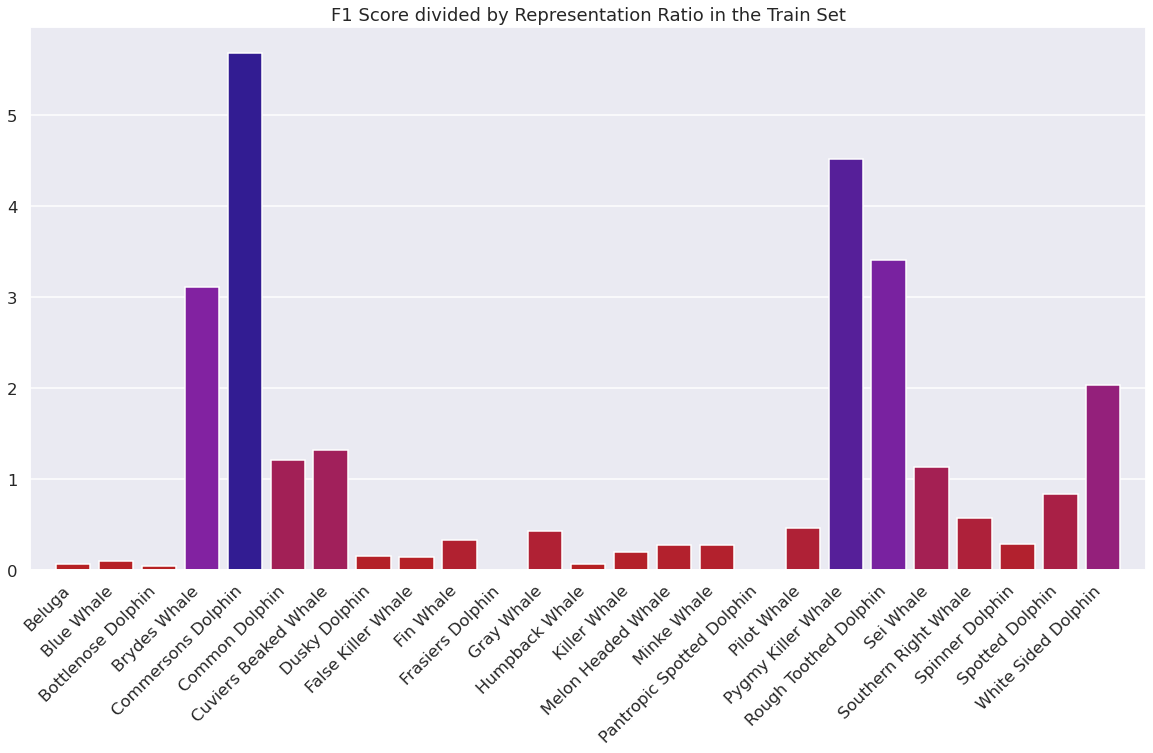

In [80]:
f1_list_proportions = [f1_list[i]/train_df_sp_proportions.iloc[i,] for i in range(0,25)]

minima = min(f1_list_proportions)
maxima = max(f1_list_proportions)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=get_continuous_cmap(['#d10808', '#980eb9', '#2608a6']))

sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=species_list_title, y=f1_list_proportions, palette=[mapper.to_rgba(v) for v in f1_list_proportions])
ax.set(xlim=(-1, 25))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_title('F1 Score divided by Representation Ratio in the Train Set');

So as it turns out, relative to the number of images in the training set, our model actually performs rather well on pygmy killer whales and rough-toothed dolphins. It's possible that, given the relatively good representation of pantropical spotted dolphins in the train set, the issue there is that perhaps they look decently similar to other dolphins; for the seven pantropical spotted dolphins in the test set, four of the model's guesses were false killer whales and one was for spotted dolphin, so this seems like a possibility. Lastly, for Frasier's dolphins, this is actually the least represented class in the dataset, with only twelve images in the train set and one in the test set, so the low representation is likely responsible for the poor score.

### One additional round of training, since it's ready to go

We turned out to have a small amount of time to do some extra training on the GPU. It'll be nice to see if we can get to maybe 97% or 98%, so we'll do everything from above once more and see what comes out.

In [33]:
filepath = 'models/best_model_densenet2_add.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=15)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [33]:
image_size = (96, 96)
batch_size = 24
color_mode = 'rgb'

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    color_mode=color_mode,
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(.025)
    ]
)

In [33]:
load_file = 'models/best_model_densenet2.hdf5'

In [34]:
densenet2 = load_model(load_file)

In [ ]:
history3_densenet2 = densenet2.fit(train_ds_sp,
                                   epochs=80,
                                   validation_data=val_ds_sp,
                                   callbacks=callbacks)

In [39]:
load_file = 'models/best_model_densenet2_add.hdf5'

In [40]:
best_model_densenet2 = load_model(load_file)

In [43]:
best_model_densenet2.evaluate(test_ds_sp)

107/107 [==============================] - 23s 183ms/step - loss: 0.2085 - accuracy: 0.9577


[0.2084684520959854, 0.9576802253723145]

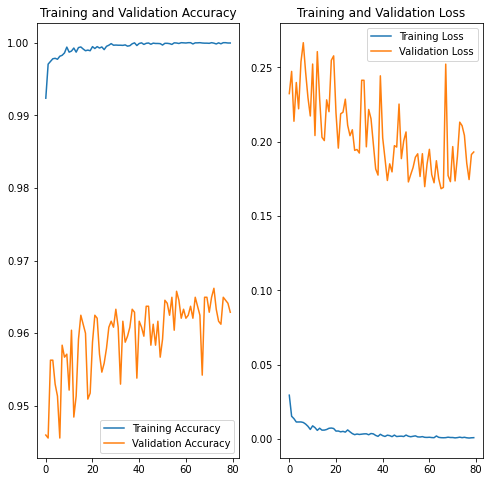

In [44]:
acc = history3_densenet2.history['accuracy']
val_acc = history3_densenet2.history['val_accuracy']

loss = history3_densenet2.history['loss']
val_loss = history3_densenet2.history['val_loss']

epochs_range = range(80)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So validation accuracy is still going up, very modestly, and validation loss is still going down (although both look like they may be tapering off). This seems to indicate that the 1 or 2 percentage points we were shooting for would take significantly longer to achieve, though at least they seem possible. We'll let it be done here for now though, since our test accuracy is identical to before which means the model is getting the same number of images wrong. 

Found 1 files belonging to 25 classes.
common_dolphin makes up ca. 1% of the training dataset.


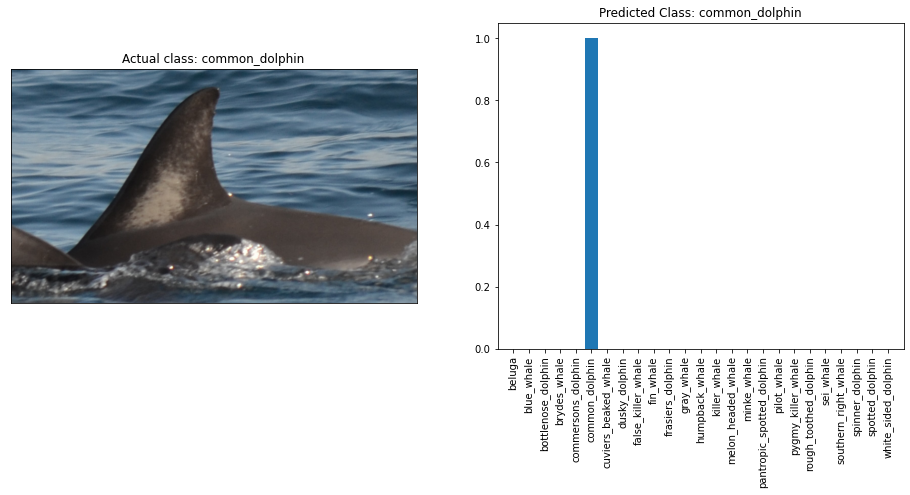

In [58]:
# Run this until you find a bad one, just to see
random_prediction(best_model_densenet2)

In [41]:
y_proba = []
y_pred = []
y_true = []

for image_batch, label_batch in test_ds_sp:
    y_true.append(label_batch)
    preds = best_model_densenet2.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))
    y_proba.append(preds)

test_labels = tf.concat([item for item in y_true], axis = 0)
y_hat = tf.concat([item for item in y_pred], axis = 0)

In [42]:
y_proba_lists = [array.tolist() for array in y_proba]

In [43]:
y_probas = []

for list_batch in y_proba_lists:
    for sub_list in list_batch:
        y_probas.append(sub_list)

In [44]:
cf_matrix = confusion_matrix(test_labels, y_hat)

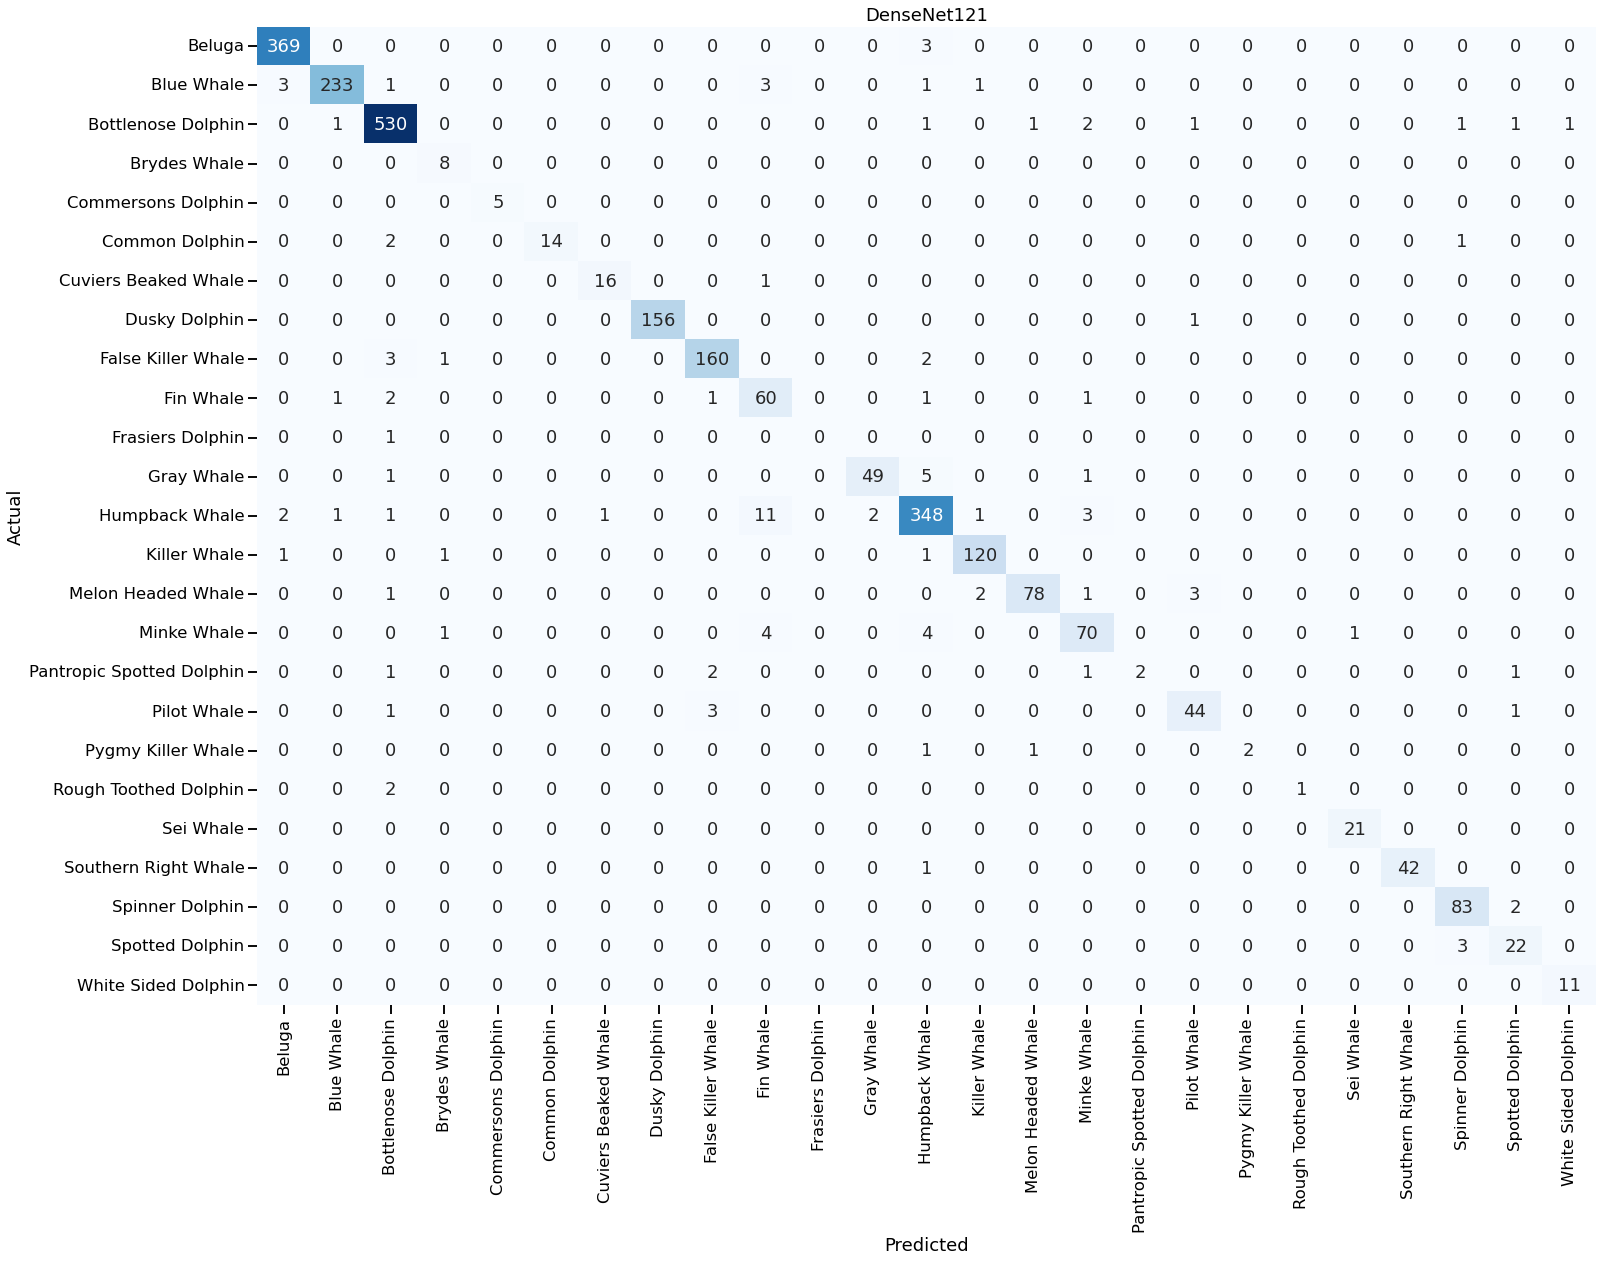

In [45]:
categories = species_list_title

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels_1 = group_counts_1
labels_1 = np.asarray(labels_1).reshape(25,25)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(24,18))

sns.heatmap(cf_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('DenseNet121');

In [46]:
print('Recall:    {}'.format(recall_score(test_labels, y_hat, average='weighted')))
print('Precision: {}'.format(precision_score(test_labels, y_hat, average='weighted', zero_division=0)))
print('Accuracy:  {}'.format(accuracy_score(test_labels, y_hat)))
print('F1 score:  {}'.format(f1_score(test_labels, y_hat, average='weighted')))
print('AUROC:     {}'.format(roc_auc_score(test_labels, y_probas, multi_class='ovr', average='weighted')))

Recall:    0.957680250783699
Precision: 0.9589654364577979
Accuracy:  0.957680250783699
F1 score:  0.9570160054702838
AUROC:     0.9989562196633226


So there are slight differences in this confusion matrix and scoring metrics. It would seem that the model made very slight improvements for some species while getting slightly worse for others. We'll once again take a look at specifically which classes are well predicted and which are poorly predicted.

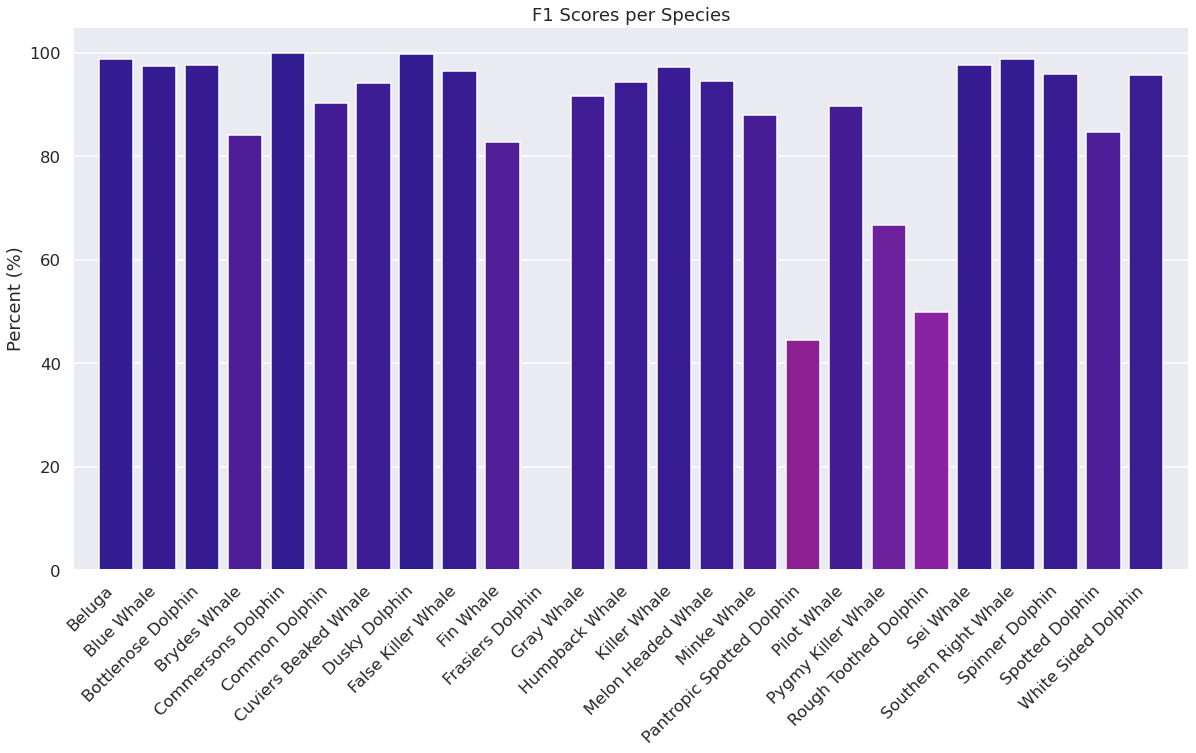

In [59]:
f1_list = [f1_score(test_labels, y_hat, labels=[i], average='weighted') for i in range(0,25)]

minima = min(f1_list)
maxima = max(f1_list)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=get_continuous_cmap(['#d10808', '#980eb9', '#2608a6']))

sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=species_list_title, y=[f1_score(test_labels, y_hat, labels=[i], average='weighted')*100 for i in range(0,25)], palette=[mapper.to_rgba(v) for v in f1_list])
ax.set(xlim=(-1, 25), ylim=(0, 105))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_ylabel('Percent (%)')
ax.set_title('F1 Scores per Species');

So our problem species are still Frasier's dolphins, pantropical spotted dolphins, rough-toothed dolphins, and pygmy killer whales. However, all but Frasier's dolphin seem to have made slight improvements (again, presumably at the cost of other species accuracy). So even though our accuracy stayed exactly the same, this is desirable, since the model does at least ok for all but one species.

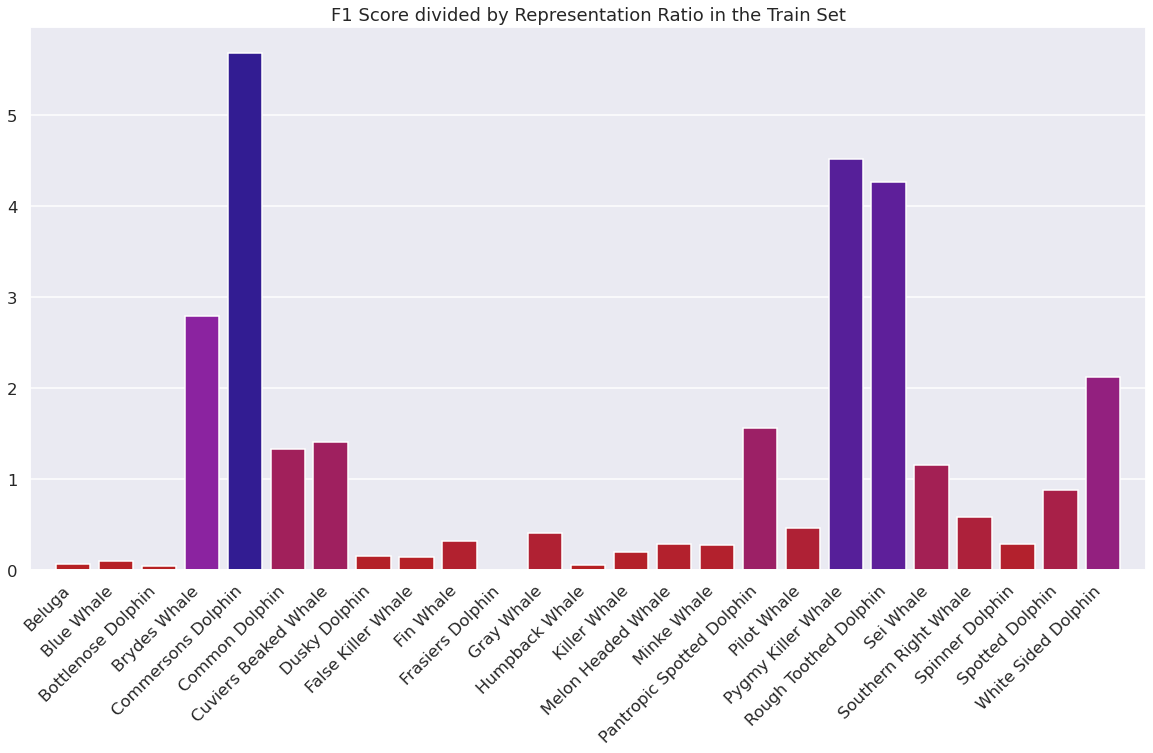

In [65]:
f1_list_proportions = [f1_list[i]/train_df_sp_proportions.iloc[i,] for i in range(0,25)]

minima = min(f1_list_proportions)
maxima = max(f1_list_proportions)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=get_continuous_cmap(['#d10808', '#980eb9', '#2608a6']))

sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=species_list_title, y=f1_list_proportions, palette=[mapper.to_rgba(v) for v in f1_list_proportions])
ax.set(xlim=(-1, 25))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.set_title('F1 Score divided by Representation Ratio in the Train Set');

This shows us more or less what we saw above, pantropical spotted dolphins and perhaps one or two other species performed slightly better, though perhaps at the expense some of the formerly better performing species (a decent trade-off, to be sure). 

Lastly, for an even more wholistic understanding of the model's shortcomings, let's take a look at every photo in the test set that it mis-identified.

In [33]:
def get_mistakes(model):

    global mistakes_list
    mistakes_list = []
     
    for i in range(len(test_df_sp)):
        random_image_df = pd.DataFrame(test_df_sp.iloc[i,:]).T

        actual_class = random_image_df['species'].values[0]

        image_size = tuple(list(model.layers[0].input.shape)[1:3])

        if list(model.layers[0].input.shape)[3] == 3:
            color_mode = 'rgb'
        elif list(model.layers[0].input.shape)[3] == 1:
            color_mode = 'grayscale'

        img = keras.preprocessing.image.load_img(os.path.join(kaggle_data_dir, random_image_df['image'].values[0]), 
                                                              target_size=image_size,
                                                              color_mode=color_mode,
                                                              interpolation='bilinear'
                                                              )

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        random_image_pred = model.predict(img_array)
        random_image_class = random_image_df.values[0][1]
        random_image_class_index = species_list.index(random_image_class)

        rand_img_pred_list = list(random_image_pred[0])
        rand_img_class_pred_index = np.where(random_image_pred == np.amax(random_image_pred))[1][0]
        rand_img_class_pred = species_list[rand_img_class_pred_index]

        if rand_img_class_pred != random_image_class:
            mistakes_list.append(random_image_df['image'])

In [34]:
def show_mistakes():    
    row = len(mistakes_list) // 3
    col = len(mistakes_list) % 3

    if len(mistakes_list) < 4:
        ncols=len(mistakes_list)
        nrows=1
    else:
        ncols=3
        if col != 0:
            nrows=row+1
        else:
            nrows=row

    sns.set_context('talk')
    fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

    for i, image in enumerate(mistakes_list):
        
        random_image = os.path.join(kaggle_data_dir, mistakes_list[i].values[0])
        random_image_pil = PIL.Image.open(random_image)

        row = i // 3
        col = i % 3

        if nrows < 2:
            ax = axes[col]
        else:
            ax = axes[row][col]
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(random_image_pil)
        ax.set_title(' '.join(list(test_df_sp[test_df_sp['image'] == mistakes_list[i].values[0]]['species'])[0].split('_')).title());

In [35]:
get_mistakes(best_model_densenet2)

In [ ]:
show_mistakes()

# Note: the output of this cell has been supressed so that the notebook will render on GitHub.

Indeed, these are more or less the same, so with that, we'll move onto deployment. Gradio has a nice simple interface that has the features we need to make this a fully functioning web app that can be used easily with a smartphone (the Gradio upload box engages the phone's camera OR file system according to user choice, exactly what we want). Eventually once we have the app the way we want it, we can deploy it for free to huggingface.co. 

# Gradio Test

In [386]:
import gradio as gr

load_file = 'models/best_model_densenet2.hdf5'
model = load_model(load_file)

labels = species_list_title

img_resize = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(96, 96, interpolation='bilinear')
    ]
)

def classify_image(inp):
    
    inp = img_resize(inp)
    img_array = keras.preprocessing.image.img_to_array(inp)
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array).flatten()
    return {labels[i]: float(prediction[i]) for i in range(25)}


image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(
    fn=classify_image,
    inputs=image,
    outputs=label,
).launch(share=True)

Running on local URL:  http://127.0.0.1:7865/
Running on public URL: https://36259.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f50aca24a30>,
 'http://127.0.0.1:7865/',
 'https://36259.gradio.app')

# Anomaly detection

So, until now, our model will only predict which species it believes an image to contain, but not whether an image even contains a whale or a dolphin to begin with. This would be useful to have, so we'll see if we can't do something about that here.

The quickest and easiest way to do this without training a new network (which, given more time, would likely be the more accurate and appropriate way of going about it) would be to look at the log-odds for a given image and compare it to the distribution of log-odds for the entire whale/dolphin dataset. We could set a z-score threshold and say anything above it is likely not a whale or a dolphin. Alternatively, in order to be a little more precise, we could grab another dataset (in this case, a small sample of ImageNet images), and we could calculate an image's z-score for both datasets' log-odds distributions. We could say that if the z-score for the whale/dolphin distribution is higher than the z-score for the non-whale/dolphin distribution (or their absolute values, rather), then we will say the image likely does not contain a whale or a dolphin. We can run the anomaly detector on both datasets and calculate an accuracy and confusion matrix for it as well. 

To get the log-odds, we'll take our DenseNet and set the output layer's activation function to linear instead of softmax. This is a nice and simple solution, because it utilizes the network that we've already trained to detect anomalies.

(To reproduce this notebook, the ImageNet data can be downloaded from here: https://www.kaggle.com/ifigotin/imagenetmini-1000. It should be unzipped into data/not-whales-or-dolphins, and the folders containing killer whales and grey whales should be deleted.)

In [6]:
densenet_base = tf.keras.applications.DenseNet121(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=(96, 96, 3), 
                                                  pooling='max')

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(.025)
    ]
)

In [10]:
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(x)
x = densenet_base(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005))(x)
outputs = layers.Dense(25, activation='linear')(x)

anomaly_detector = keras.Model(inputs, outputs, name='anomaly_detector')

adam = Adam(learning_rate=.1)
anomaly_detector.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
anomaly_detector.load_weights('models/best_model_densenet2_add.hdf5')

In [75]:
# anomaly_detector.save('models/anomaly_detector.hdf5')

In [12]:
image_size = (96, 96)
batch_size = 24
color_mode = 'rgb'

anom_ds = tf.keras.preprocessing.image_dataset_from_directory('data/not-whales-or-dolphins/imagenet-mini/train',
                                                              color_mode=color_mode,
                                                              image_size=image_size,
                                                              batch_size=batch_size)

happy_whale_ds = tf.keras.preprocessing.image_dataset_from_directory('data/local_split/sp/train',
                                                                     color_mode=color_mode,
                                                                     image_size=image_size,
                                                                     batch_size=batch_size)

Found 34643 files belonging to 998 classes.
Found 46056 files belonging to 25 classes.


In [13]:
anom_preds = anomaly_detector.predict(anom_ds)
anom_preds_probs = [np.max(pred) for pred in anom_preds]

In [14]:
domain_preds = anomaly_detector.predict(happy_whale_ds)
domain_preds_probs = [np.max(pred) for pred in domain_preds]

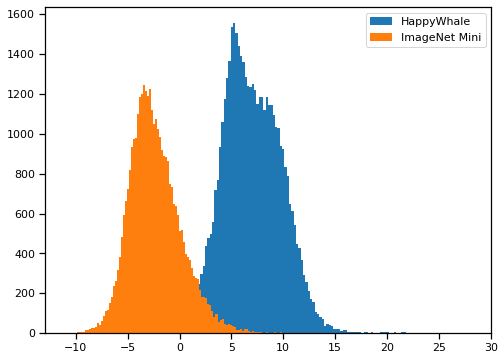

In [15]:
sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(domain_preds_probs, bins='auto', label='HappyWhale')
ax.hist(anom_preds_probs, bins='auto', label='ImageNet Mini')
ax.legend();

These distributions look normal and also look to have decent separation between them, so our strategy for our quick and dirty anomaly detector should work well enough. Let's run it on test data and see what we come up with.

In [16]:
anom_ds_test = tf.keras.preprocessing.image_dataset_from_directory('data/not-whales-or-dolphins/imagenet-mini/val',
                                                                   color_mode=color_mode,
                                                                   image_size=image_size,
                                                                   batch_size=batch_size)

happy_whale_ds_test = tf.keras.preprocessing.image_dataset_from_directory('data/local_split/sp/test',
                                                                          color_mode=color_mode,
                                                                          image_size=image_size,
                                                                          batch_size=batch_size)

Found 3916 files belonging to 998 classes.
Found 2552 files belonging to 25 classes.


In [17]:
anom_preds = anomaly_detector.predict(anom_ds_test)
anom_preds_probs = [np.max(pred) for pred in anom_preds]

In [18]:
domain_preds = anomaly_detector.predict(happy_whale_ds_test)
domain_preds_probs = [np.max(pred) for pred in domain_preds]

In [19]:
mu_happywhale = np.mean(domain_preds_probs)
sigma_happywhale = np.std(domain_preds_probs)

mu_anom = np.mean(anom_preds_probs)
sigma_anom = np.std(anom_preds_probs)

actual_positives = []

for prob in domain_preds_probs:
    
    x_happywhale = prob
    z_happywhale = abs((x_happywhale-mu_happywhale) / sigma_happywhale)

    x_anom = prob
    z_anom = abs((x_anom-mu_anom) / sigma_anom)

    if z_happywhale > z_anom:
        actual_positives.append(0)
    else:
        actual_positives.append(1)
        
actual_negatives = []

for prob in anom_preds_probs:
    
    x_happywhale = prob
    z_happywhale = abs((x_happywhale-mu_happywhale) / sigma_happywhale)

    x_anom = prob
    z_anom = abs((x_anom-mu_anom) / sigma_anom)

    if z_happywhale > z_anom:
        actual_negatives.append(0)
    else:
        actual_negatives.append(1)

In [20]:
anomaly_matrix = np.array([[actual_negatives.count(0), actual_negatives.count(1)], [actual_positives.count(0), actual_positives.count(1)]])

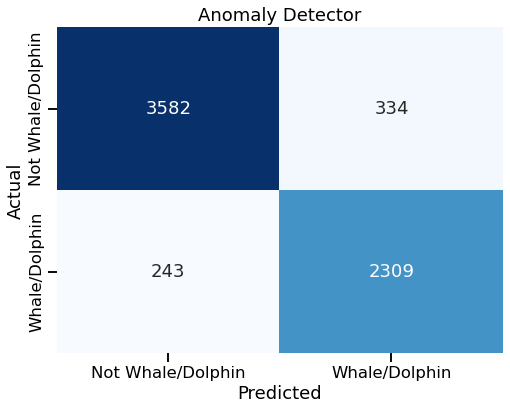

In [21]:
categories = ['Not Whale/Dolphin', 'Whale/Dolphin']

group_counts_1 = ['{0:0.0f}'.format(value) for value in anomaly_matrix.flatten()]
labels_1 = group_counts_1
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(anomaly_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Anomaly Detector');

In [22]:
print('Recall:    {}'.format(2309/(2309+243)))
print('Precision: {}'.format(2309/(2309+334)))
print('Accuracy:  {}'.format((2309+3582)/(2309+3582+243+334)))
print('F1 score:  {}'.format((2*2309)/(2*2309+243+334)))

Recall:    0.9047805642633229
Precision: 0.8736284525160802
Accuracy:  0.910791589363018
F1 score:  0.8889316650625602


These are decent scores for the anomaly detector. If they were a little worse, we might consider doing something more advanced to filter out anomalies, but since they're not, we'll go with this. We can plug the anomaly detector right into our gradio app. 

# Gradio Revision

In [5]:
import gradio as gr
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import scipy.stats as stats
import numpy as np

full_train_df = pd.read_csv('data/happy-whale-and-dolphin/train.csv')
full_train_df['species'].replace({"globis": "pilot_whale",
                          "short_finned_pilot_whale": "pilot_whale",
                          "long_finned_pilot_whale": "pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_list = list(set(full_train_df['species'].values))
species_list.sort()
species_list_title = [' '.join(species.split('_')).title() for species in species_list]

load_file = 'models/best_model_densenet2_add.hdf5'
model = load_model(load_file)

load_file = 'models/anomaly_detector.hdf5'
anom_det = load_model(load_file)

labels = species_list_title.copy()

img_resize = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(96, 96, interpolation='bilinear')
    ]
)

def classify_image(inp):
    
    inp = img_resize(inp)
    img_array = keras.preprocessing.image.img_to_array(inp)
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array).flatten()
    anom_pred = np.max(anom_det.predict(img_array)).flatten()
    
    mu_happywhale = 6.9773545
    sigma_happywhale = 2.882455
    mu_anom = -2.3123937
    sigma_anom = 2.5086358

    z_happywhale = abs((anom_pred-mu_happywhale) / sigma_happywhale)
    z_anom = abs((anom_pred-mu_anom) / sigma_anom)
    z_anom_non_abs = (anom_pred-mu_anom) / sigma_anom
    
    if z_happywhale > z_anom:
        anom_cat = 'No'
        return anom_cat, {labels[i]: float(prediction[i]) for i in range(25)}

    else:
        anom_cat = 'Yes'
        return anom_cat, {labels[i]: float(prediction[i]) for i in range(25)}
        
image = gr.inputs.Image(label='Input')
anom_label = gr.outputs.Label(label='Image contains a whale/dolphin?')
label = gr.outputs.Label(num_top_classes=3, label='Prediction')

gr.Interface(
    fn=classify_image,
    inputs=image,
    outputs=[anom_label, label],
    title='Whale and Dolphin Species Identification',
    description='Snap or upload a photo of a whale or a dolphin with your smartphone or computer! The model will tell you what species it thinks it is from a list of 25.',
    theme='dark-seafoam'
).launch()

Running on local URL:  http://127.0.0.1:7861/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x7fde70553f40>,
 'http://127.0.0.1:7861/',
 None)

# Deployment, Next Steps, Conclusion

So that works out exactly as we'd like. We'll deploy that to huggingface.co, [here](https://huggingface.co/spaces/snakeeyes021/id-the-seas), and we'll add a few example images with some extra explanation about the app. For instance, we'll want to mention that since both the species classifier and the anomaly detector are technically separate models, an image that is flagged as an anomaly will still receive a class prediction. This is desired behavior as we would still want a class prediction for false positives from the anomaly detector. The app works on smartphone or computer. Either platform can upload images, but, as pointed out earlier, use on a smartphone allows for capturing images with the phone's camera. 

At this point, I'm satisfied with the species ID results; they could be slightly better, and perhaps I'll revisit them at some future point, but for now, with the Happywhale/Kaggle competition deadline approaching, I'd like to turn my attention to the problem of individual whale/dolphin ID. This will involve the use of techniques and models common to facial recognition. To see progress or results on that, find the individual-id branch in this repo.

To conclude, we've managed to achieve a high level of accuracy in the identification of whale and dolphin species, utilizing images of just dorsal fins. I've actually already had multiple friends/colleagues tell me they were planning on using the app when they were next at the beach or on the water, which, in my mind constitutes success for the particular problem it set out to solve. We've made something of use for lay people. Now, onto something of use for the professionals! 